In [2]:
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

apikey = 'P6292qJXnqQ8OnoVTGmrQTOeL7ITxPadzp2Kmn8voLDgf8hUjUZAOll3jqWNaYQg'
apisecret = 'vOXpLeLba3YT1XmN5VFFLARoqDSowLTSatKVfBNLvbXX0EClqZ7EYyBjx3VJKJrX'

#Performing authentication
client = Client(apikey, apisecret)

In [3]:
quoteAssetCurrency = "USDT"

#get symbols
exchange_info = client.get_exchange_info()
dfexchange_info_symbols = pd.DataFrame (exchange_info['symbols'])
#dfexchange_info_symbols.head
dfUSDT = dfexchange_info_symbols.loc[dfexchange_info_symbols ['quoteAsset'] == quoteAssetCurrency]
dfUSDT.dtypes


symbol                        object
status                        object
baseAsset                     object
baseAssetPrecision             int64
quoteAsset                    object
quotePrecision                 int64
quoteAssetPrecision            int64
baseCommissionPrecision        int64
quoteCommissionPrecision       int64
orderTypes                    object
icebergAllowed                  bool
ocoAllowed                      bool
quoteOrderQtyMarketAllowed      bool
allowTrailingStop               bool
cancelReplaceAllowed            bool
isSpotTradingAllowed            bool
isMarginTradingAllowed          bool
filters                       object
permissions                   object
dtype: object

In [4]:
#for hd in dfUSDT['symbol']:
BTCUSDT_historical_data = client.get_historical_klines('BTCUSDT', Client.KLINE_INTERVAL_1MONTH)
df_BTCUSDT_historical_data = pd.DataFrame(BTCUSDT_historical_data)
df_BTCUSDT_historical_data.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 
                                      'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore']
df_BTCUSDT_historical_data['Open Time'] = pd.to_datetime(df_BTCUSDT_historical_data['Open Time']/1000, unit='s')
df_BTCUSDT_historical_data['Close Time'] = pd.to_datetime(df_BTCUSDT_historical_data['Close Time']/1000, unit='s')

numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume']
#Conversion to numerical type
df_BTCUSDT_historical_data[numeric_columns] = df_BTCUSDT_historical_data[numeric_columns].apply(pd.to_numeric, axis=1)
#df_BTCUSDT_historical_data.mean(axis='index')
BTCUSDT_Volume = df_BTCUSDT_historical_data['Volume'].mean(axis='index')
BTCUSDT_Volume

1594144.8089785832

We build a new list containing the quote currency USDT

In [7]:
#https://stackoverflow.com/questions/33907776/how-to-create-an-array-of-dataframes-in-python
hf ={}#it is a list of dataframe
Columuns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 
            'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore']
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume']
for USDTsymbol in dfUSDT['symbol']:
    tmp = client.get_historical_klines(USDTsymbol, Client.KLINE_INTERVAL_1MONTH, start_str = '29 June 2022', limit = 2)
    df_tmp = pd.DataFrame(tmp)
    if len(df_tmp.columns) == 0:
        continue
    df_tmp.columns = Columuns
    df_tmp['Open Time']     = pd.to_datetime(df_tmp['Open Time']/1000, unit='s')
    df_tmp['Close Time']    = pd.to_datetime(df_tmp['Close Time']/1000, unit='s')
    df_tmp[numeric_columns] = df_tmp[numeric_columns].apply(pd.to_numeric, axis=1)
    hf[USDTsymbol]          = pd.DataFrame(df_tmp, columns=Columuns)
    #hf.append(USDTsymbol)
    #hf[USDTsymbol].append(tmp)   
#    if df_tmp ['Volume'].mean(axis='index')/BTCUSDT_Volume > 10:
#        print (df_tmp ['Volume'].mean(axis='index')/BTCUSDT_Volume)
#        hf.append(tmp)
#        i += 1

... with a certain Volume

In [ ]:
tmp_mean_BTCUSDT = hf['BTCUSDT']['TB Quote Volume'].mean(axis='index')
Big_Volume_Symbols = []
level_of_volume_acceptance = 0.005
i=0
for USDTsymbol in hf.keys():
    tmpMean = hf[USDTsymbol]['TB Quote Volume'].mean(axis='index')
    if tmpMean/tmp_mean_BTCUSDT > level_of_volume_acceptance and len(hf[USDTsymbol]['TB Quote Volume']>0):
        #print(i, ", ", USDTsymbol, ", ", hf[USDTsymbol]['TB Quote Volume'])
        i+=1
        Big_Volume_Symbols.append(USDTsymbol)

Once we get the pairs, I retrive the datas.

In [ ]:
import requests
import json
import time
import datetime as dt

url = 'https://api.binance.com/api/v3/klines'

Now = time.time() #timestamp
data = {}
for sym in Big_Volume_Symbols:
    # interval = '1d'
    interval = '1h'
    # interval = '1m'
    #31536000 seconds in a year
#    start = str(int( (Now - 31536000)*1000 ) )
    start = str(int( (Now - 2592000)*1000 ) )
    # start = str(int( (Now - 160000)*1000 ) )
    end = str(int(Now*1000))
    par = {'symbol': sym, 'interval': interval, 'startTime': start, 'endTime': end}
    data[sym] = pd.DataFrame(json.loads(requests.get(url, params= par).text))
    #format columns name
    if len(data[sym].columns)==0:
        print(sym, " issue = (data.columns)==0")
        continue
    #ze create the columns
    data[sym].columns = ['datetime', 'open', 'high', 'low', 'close', 'volume','close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore']
    #indexed on time
    data[sym].index = [dt.datetime.fromtimestamp(x/1000.0) for x in data[sym].datetime]
    data[sym]=data[sym].astype(float)


https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array

In [ ]:
def nan_helper(y):
#    """Helper to handle indices and logical indices of NaNs.

#    Input:
#        - y, 1d numpy array with possible NaNs
#    Output:
#        - nans, logical indices of NaNs
#        - index, a function, with signature indices= index(logical_indices),
#          to convert logical indices of NaNs to 'equivalent' indices
#    Example:
#        >>> # linear interpolation of NaNs
#        >>> nans, x= nan_helper(y)
#        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
#    """

    return np.isnan(y), lambda z: z.to_numpy().nonzero()[0]

def log_Transform (data):
#    """Helper to handle indices and logical indices of NaNs.

#    Input:
#        - data, 1d numpy array with possible NaNs
#    Output:
#        - log return, 1d
#    Example:
#        >>> log_return = log_Transform(data [sym].close)
#    """
    log_return = np.log(data) - np.log(data.shift(1))
    nans, x = nan_helper(log_return)
    log_return[nans] = np.interp(x(nans), x(~nans), log_return[~nans])
    return log_return


We check for Unit Root with Augmented Dickey-Fuller test

In [ ]:
from statsmodels.tsa.stattools import adfuller
#https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html?highlight=adf
#https://stackoverflow.com/questions/31287552/logarithmic-returns-in-pandas-dataframe

pvalue = 0.0001
i = 0
statresult = {}
dfoutput = {}
for sym in Big_Volume_Symbols:
    #We do a log-return
    log_return = log_Transform(data [sym].close)
    
    #perform augmented Dickey-Fuller test
    statresult[sym] = adfuller(log_return, autolag="AIC")
    dfoutput[sym] = pd.Series(
        statresult[sym][0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    #We build the sub-series with the critical values
    for key, value in statresult[sym][4].items():
        dfoutput[sym]["Critical Value (%s)" % key] = value

    #if dfoutput[sym]["Critical Value (10%)"] > dfoutput[sym]['Test Statistic'] :
    if float (dfoutput[sym]["p-value"]) < pvalue :
        i += 1
        #print(dfoutput[sym])
        print(i, ". Symbol = ", sym, ", p-value = ", float (dfoutput[sym]["p-value"]))

1 . Symbol =  BTCUSDT , p-value =  2.668580384583284e-06
2 . Symbol =  ETHUSDT , p-value =  7.527815751929859e-07
3 . Symbol =  BNBUSDT , p-value =  1.1670526594945855e-05
4 . Symbol =  LTCUSDT , p-value =  2.2458493119720283e-05
5 . Symbol =  XRPUSDT , p-value =  1.3153752295216493e-05
6 . Symbol =  TRXUSDT , p-value =  1.2460815996901981e-09
7 . Symbol =  ETCUSDT , p-value =  3.373955592881473e-07
8 . Symbol =  USDCUSDT , p-value =  6.944559661301164e-21
9 . Symbol =  LINKUSDT , p-value =  2.981449834062396e-08
10 . Symbol =  WAVESUSDT , p-value =  4.5878018780487896e-08
11 . Symbol =  MATICUSDT , p-value =  2.2879246474022565e-08
12 . Symbol =  ATOMUSDT , p-value =  5.61351751413305e-09
13 . Symbol =  FTMUSDT , p-value =  1.6991633279282677e-07
14 . Symbol =  DOGEUSDT , p-value =  1.4242740875676292e-06
15 . Symbol =  BUSDUSDT , p-value =  6.923324718149054e-08
16 . Symbol =  EURUSDT , p-value =  1.7982571622882015e-10
17 . Symbol =  SOLUSDT , p-value =  5.181518254116302e-07
18 . S

https://nbviewer.org/github/mapsa/seminario-doc-2014/blob/master/cointegration-example.ipynb

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def get_johansen(y, p):

        """
        Get the cointegration vectors at 95% level of significance
        given by the trace statistic test.
        """

        N, col = y.shape
        jres = coint_johansen(y, 0, p)
        trstat = jres.lr1                       # trace statistic
        tsignf = jres.cvt                       # critical values

        j=2
        for i in range(col):
            if trstat[i] > tsignf[i, j]:     # 0: 90%  1:95% 2: 99%
                r = i + 1
        jres.r = r
        jres.evecr = jres.evec[:, :r]

        return jres

We now perform a test of Johansen Cointegration Test

In [ ]:
p = 1

log_return_BTC = np.array (log_Transform(data ['BTCUSDT'].close))
log_return_ETH = np.array (log_Transform(data ['ETHUSDT'].close))
log_return_BNB = np.array (log_Transform(data ['BNBUSDT'].close))
#log_return = np.array ( [log_return, np.array (log_Transform(data ['ETHUSDT'].close))] )
y = pd.DataFrame(index=data['BTCUSDT'].index, data={'BTCUSDT': log_return_BTC, 'ETHUSDT': log_return_ETH, 'BNBUSDT': log_return_BNB} )
#print (log_return)
jres = get_johansen(y, p)

print ("There are ", jres.r, "cointegration vectors")

v =  np.array ([np.ones(3), jres.evecr[:,0], jres.evecr[:,1]])
M = np.asmatrix (v)
print(v)
#v3=jres.evec[:,2]  # v3 is not a cointegration vector

There are  3 cointegration vectors
[[   1.            1.            1.        ]
 [ 162.80037829  -78.50578597   58.44995984]
 [-403.62233254  198.72639659  149.57607755]]


In [ ]:
# If we apply vector v1 we get a I(0) time series
print ("v1 = ", v[1,:])
BTC = np.array (data ['BTCUSDT'].close)
ETH = np.array (data ['ETHUSDT'].close)
BNB = np.array (data ['BNBUSDT'].close)
price_series = pd.DataFrame(index=data['BTCUSDT'].index, data={'BTCUSDT': BTC, 'ETHUSDT': ETH, 'BNBUSDT': BNB} )
spread_average = np.mean (np.dot(price_series, v[1,:]))
spread_average *= np.ones(len(data['BTCUSDT'].index))
spread = np.dot(price_series, v[1,:])

plt.plot(data['BTCUSDT'].index, spread, data['BTCUSDT'].index, spread_average)
plt.gcf().autofmt_xdate()
plt.plot()

NameError: name 'v' is not defined

We now perform a Stationarity Test (Dickey-Fuller)

In [ ]:
def ADF(v, crit='5%', max_d=6, reg='n', autolag='AIC'):
    """ Augmented Dickey Fuller test

    Parameters
    ----------
    v: ndarray matrix
        residuals matrix

    Returns
    -------
    bool: boolean
        true if v pass the test 
    """

    boolean = False

    
    adf = adfuller(v, max_d, reg, autolag)
    print (adf)
    if(adf[0] < adf[4][crit]):
        pass
    else:
        boolean = True

    return boolean

In [ ]:
if ADF(np.dot(price_series, v[1,:])) and not ADF(np.diff(np.dot(price_series, v[1,:]))):
    print("YES, unit root hypothesis can't be rejected")
else:
    print("NO, unit root hypothesis has been be rejected")

(0.3322066341066208, 0.7834772066830222, 3, 496, {'1%': -2.570262404233871, '5%': -1.9415549543542014, '10%': -1.616295340070984}, 9516.085789933655)
(-11.204714394406022, 2.716258316690927e-20, 2, 496, {'1%': -2.570262404233871, '5%': -1.9415549543542014, '10%': -1.616295340070984}, 9495.347656412172)
YES, unit root hypothesis can't be rejected


Ornstein-Ulhenbeck and Maximum Likelihood

dSt = llambda*(mu-St) * dt+sigma * dWt

see https://www.statisticshowto.com/wp-content/uploads/2016/01/Calibrating-the-Ornstein.pdf

In [ ]:
def MLE_for_OU(x):
    N = len(x)
    Sx  = np.sum(x[0:N-2])
    Sy  = np.sum(x[1:N-1])
    xx  = np.power(x,2)
    Sxx = np.sum(xx[0:N-2])
    Syy = np.sum(xx[1:N-1]) 
    Sxy = sum(x[0:N-2] * x[1:N-1])
    #86400==number of seconds in 24 hours
    delta = 1.0/86400.0 #timestep

    mu = (Sy*Sxx-Sx*Sxy)/(N*(Sxx-Sxy)-(Sx**2-Sx*Sy))
    llambda = -1.0/delta*np.log((Sxy-mu*Sx-mu*Sy+N*mu**2)/(Sxx-2.0*mu*Sx+N*mu**2))
    alpha = np.exp(-llambda*delta)
    sigma_hat2 = 1.0/N*(Syy-2.0*alpha*Sxy+alpha**2.0*Sxx
                - 2.0*mu*(1.0-alpha)*(Sy-alpha*Sx)+N*mu**2*(1.0-alpha)**2)
    sigma = np.sqrt(sigma_hat2*2.0*llambda/(1.0-alpha**2))

    return mu, llambda, sigma

Another Calibration Method

In [ ]:
from sklearn.linear_model import LinearRegression

def estimate_OU_params(X_t):
    """
    Estimate OU params from OLS regression.
    - X_t is a 1D array.
    Returns instance of OUParams.
    """
    y = np.diff(X_t)
    X = X_t[:-1].reshape(-1, 1)
    reg = LinearRegression(fit_intercept=True)
    reg.fit(X, y)
    # regression coeficient and constant
    llambda = -reg.coef_[0]
    mu = reg.intercept_ / llambda
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    sigma = np.std(y - y_hat)
    return mu, llambda, sigma

More llambda is high more the process is mean reverting

In [ ]:
spread = spread/max(spread) #renormalisation
mu, llambda, sigma = MLE_for_OU (spread)
print ("(mu, llambda, sigma)=", mu, " ," , llambda, " ," , sigma)

mu2, llambda2, sigma2 = estimate_OU_params (spread)
print ("(mu, llambda, sigma)=", mu2, " ," , llambda2, " ," , sigma2)


(mu, llambda, sigma)= 1.0855357786711273  , 20.785309937829684  , 0.5098880013413866
(mu, llambda, sigma)= 0.9700152569247792  , 0.005422292885102866  , 0.0017347287225077648


Let s simulate an Ornstein Ulhenbeck

(array([0.94 , 0.945, 0.95 , 0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 ,
        0.985, 0.99 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

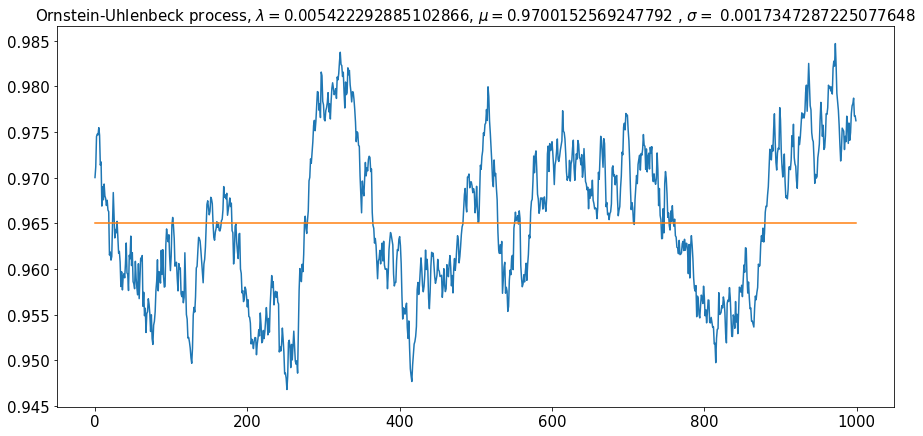

In [ ]:
import OU as ou

#OU_params = ou.OUParams(alpha=llambda, gamma=mu, beta=sigma)
OU_params = ou.OUParams(alpha=llambda2, gamma=mu2, beta=sigma2)
OU_proc = ou.get_OU_process(1_000, OU_params)
OU_proc_average = np.mean (OU_proc)
OU_proc_average = OU_proc_average*np.ones(len(OU_proc))
#----------------------------------------------------
# plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))

title = "Ornstein-Uhlenbeck process, "
title += r"$\lambda=$"+str(float(llambda2))
title += r", $\mu =$"+str(float(mu2))
title += r" , $\sigma =$ "+str(float(sigma2))
plt.plot(OU_proc)
plt.plot(OU_proc_average)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)